In [1]:
from tensorflow.keras.layers import BatchNormalization, ReLU, Conv2D, Add, GlobalAveragePooling2D, Dense, Input, Conv2DTranspose, Reshape, Activation, Flatten, Embedding, Concatenate, AveragePooling2D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
(train_imgs, train_labels), (test_imgs, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
print(train_imgs.shape, test_imgs.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [5]:
np.random.seed(42)

# Generate random indices
random_indices = np.random.choice(len(train_imgs), size=1000, replace=False)

# Select random images and labels
random_train_imgs = train_imgs[random_indices]
random_train_labels = train_labels[random_indices]

In [6]:
print("Shape of random_train_imgs:", random_train_imgs.shape)
print("Shape of random_train_labels:", random_train_labels.shape)

Shape of random_train_imgs: (1000, 32, 32, 3)
Shape of random_train_labels: (1000, 1)


In [7]:
# Resize images
resized_images = tf.image.resize(random_train_imgs, [256, 256])

In [8]:
print(resized_images.shape)

(1000, 256, 256, 3)


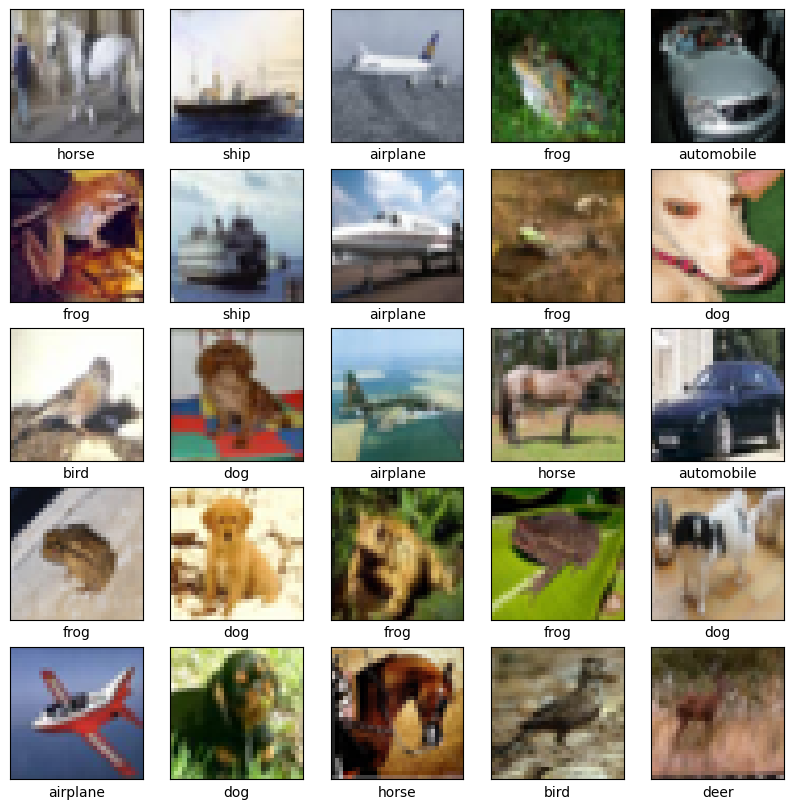

In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(random_train_imgs[i])
  plt.xlabel(class_names[random_train_labels[i][0]])

plt.show()

In [10]:

#normalize resized images
normalized_resized_images = resized_images / 255.0
test_images = test_imgs / 255.0

In [11]:
num_classes = 10
train_labels = tf.keras.utils.to_categorical(random_train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

In [12]:
print(train_labels)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [14]:
# Create a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((resized_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_imgs, test_labels))

In [15]:
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [16]:
def classifier():
  base_model = ResNet50(
      input_shape=(256, 256, 3),
      include_top = False,
      weights = 'imagenet'
  )

  x = base_model.output
  x = GlobalAveragePooling2D()(x)

  number_of_classes = 10

  # multilayer perceptron with 2 residual blocks and skip connections
  shortcut = x


  x = Dense(512, activation='relu')(x)
  x = Dense(2048, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = Concatenate()([x, shortcut])

  shortcut = x

  x = Dense(512, activation='relu')(x)
  x = Dense(2048, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = Concatenate()([x, shortcut])

  preds = Dense(number_of_classes, activation="softmax")(x)

  #create model for classifier

  model = Model(inputs=base_model.input, outputs=preds)

  return model



In [17]:
classifier = classifier()

94765736/94765736 [==============================] - 1s 0us/step


In [18]:
def orthogonal_regularizer(scale) :
  """ Defining the Orthogonal regularizer and return the function at last to be used in Conv layer as kernel regularizer"""

  def ortho_reg(w) :
      """ Reshaping the matrxi in to 2D tensor for enforcing orthogonality"""
      _, _, _, c = w.get_shape().as_list()

      w = tf.reshape(w, [-1, c])

      """ Declaring a Identity Tensor of appropriate size"""
      identity = tf.eye(c)

      """ Regularizer Wt*W - I """
      w_transpose = tf.transpose(w)
      w_mul = tf.matmul(w_transpose, w)
      reg = tf.subtract(w_mul, identity)

      """Calculating the Loss Obtained"""
      ortho_loss = tf.nn.l2_loss(reg)

      return scale * ortho_loss

  return ortho_reg

In [19]:
from keras.layers.pooling.max_pooling2d import MaxPooling2D
weight_init = tf.initializers.truncated_normal(mean=0.0, stddev=0.02)
weight_regularizer = orthogonal_regularizer(0.0001)


def global_sum_pooling(x) :
    gsp = tf.reduce_sum(x, axis=[1, 2], keepdims=True)
    return gsp

def max_pooling(x) :
    x = MaxPooling2D(pool_size=2, strides=2, padding='SAME')(x)
    return x

def hw_flatten(x) :
    return tf.reshape(x, shape=[x.shape[0], -1, x.shape[-1]])


def _l2normalize(v, eps=1e-12):
  """l2 normize the input vector."""
  return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)

def spectral_normalization(name, weights, num_iters=1, update_collection=None,
                           with_sigma=False):
  w_shape = weights.shape.as_list()
  w_mat = tf.reshape(weights, [-1, w_shape[-1]])  # [-1, output_channel]
  u = tf.compat.v1.get_variable(name + 'u', [1, w_shape[-1]],
                      initializer=tf.keras.initializers.TruncatedNormal(),
                      trainable=False)
  u_ = u
  for _ in range(num_iters):
    v_ = _l2normalize(tf.matmul(u_, w_mat, transpose_b=True))
    u_ = _l2normalize(tf.matmul(v_, w_mat))

  sigma = tf.squeeze(tf.matmul(tf.matmul(v_, w_mat), u_, transpose_b=True))
  w_mat /= sigma
  if update_collection is None:
    with tf.control_dependencies([u.assign(u_)]):
      w_bar = tf.reshape(w_mat, w_shape)
  else:
    w_bar = tf.reshape(w_mat, w_shape)
    if update_collection != 'NO_OPS':
      tf.add_to_collection(update_collection, u.assign(u_))
  if with_sigma:
    return w_bar, sigma
  else:
    return w_bar

def conv(name, inputs, nums_out, k_size, strides, update_collection=None, is_sn=False):
    nums_in = inputs.shape[-1]
    with tf.name_scope(name):
        W = tf.compat.v1.get_variable("W", [k_size, k_size, nums_in, nums_out], initializer=tf.keras.initializers.Orthogonal())
        b = tf.compat.v1.get_variable("b", [nums_out], initializer=tf.constant_initializer([0.0]))
        if is_sn:
            W = spectral_normalization("sn", W, update_collection=update_collection)
        con = tf.nn.conv2d(inputs, W, [1, strides, strides, 1], "SAME")
    return tf.nn.bias_add(con, b)


def inner_product(global_pooled, y, nums_class, update_collection=None):
    W = global_pooled.shape[-1]
    V = tf.compat.v1.get_variable("V", [nums_class, W], initializer=tf.orthogonal_initializer())
    V = tf.transpose(V)
    V = spectral_normalization("embed", V, update_collection=update_collection)
    V = tf.transpose(V)
    temp = tf.nn.embedding_lookup(V, y)
    temp = tf.reduce_sum(temp * global_pooled, axis=1, keep_dims=True)
    return temp


In [20]:
def non_local(name, inputs, update_collection, is_sn):
    h, w, num_channels = inputs.shape[1], inputs.shape[2], inputs.shape[3]
    location_num = h * w
    downsampled_num = location_num // 4
    with tf.name_scope(name):
        theta = conv("f", inputs, num_channels // 8, 1, 1, update_collection, is_sn)
        theta = tf.reshape(theta, [-1, location_num, num_channels // 8])
        phi = conv("h", inputs, num_channels // 8, 1, 1, update_collection, is_sn)
        phi = AveragePooling2D()(phi)
        phi = tf.reshape(phi, [-1, downsampled_num, num_channels // 8])
        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)
        g = conv("g", inputs, num_channels // 2, 1, 1, update_collection, is_sn)
        g = AveragePooling2D()(g)
        g = tf.reshape(g, [-1, downsampled_num, num_channels // 2])
        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, [-1, h, w, num_channels // 2])
        sigma = tf.compat.v1.get_variable("sigma_ratio", [], initializer=tf.constant_initializer(0.0))
        attn_g = conv("attn", attn_g, num_channels, 1, 1, update_collection, is_sn)
        return inputs + sigma * attn_g

In [21]:
def generator_residual_block(input_tensor, filters):
  shortcut = input_tensor

  x = BatchNormalization()(input_tensor)
  x = ReLU()(x)
  x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  shortcut = Conv2D(filters, kernel_size=(3, 3), padding='same')(shortcut)

  #add shortcut to 2nd convolutional layer
  x = shortcut + x

  return x

In [22]:
def generator_network():
  z_dim = 128
  channel_width_multiplier = 128
  number_of_classes = 10

  # z: input noise vector, y: embedding
  z_input, y_input = Input(shape=(z_dim,)), Input(shape=(number_of_classes,))

  input_concat = Concatenate()([z_input, y_input])
  #generator layers
  #TODO: use a loop to clean up code

  ch = channel_width_multiplier * 16

  x = Dense(4 * 4 * ch, activation='relu')(input_concat)
  print("shape", x.shape)
  x = tf.keras.layers.Reshape((4, 4, ch))(x)

  print(x.shape)
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)
  ch = ch // 2
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)
  ch = ch // 2
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)
  ch = ch // 2
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)

  #TODO: Add Non-Local Block
  x = non_local("Non-Local", x, None, True)

  ch = ch // 2
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)

  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(3, kernel_size=3, padding='same', activation='tanh')(x)
    
  print(x.shape)  

  model = tf.keras.models.Model(inputs=[z_input, y_input], outputs=x)

  return model



In [23]:
generator = generator_network()

shape (None, 32768)
(None, 4, 4, 2048)
(None, 8, 8, 2048)
(None, 16, 16, 1024)
(None, 32, 32, 1024)
(None, 64, 64, 512)
(None, 128, 128, 256)
(None, 256, 256, 128)
(None, 256, 256, 3)


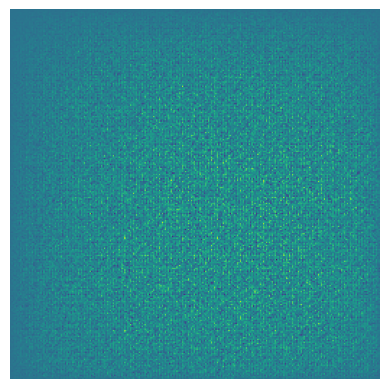

In [24]:
z_dim = 128
num_classes = 10
z = np.random.normal(size=(1, z_dim))
y = np.random.randint(0, num_classes, size=(1, num_classes))

generated_image = generator([z, y], training=False)


# Display the generated image
plt.imshow(generated_image[0, :, :, 0])
plt.axis('off')
plt.show()


In [25]:
def discriminator_residual_block(input_tensor, filters):
  shortcut = input_tensor

  x = ReLU()(input_tensor)

  x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  x = ReLU()(x)

  x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  #add shortcut to 2nd convolutional layer

  shortcut = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  return x + shortcut

In [26]:
from keras.layers.pooling.average_pooling2d import AveragePooling2D
def discriminator_network():
  input_shape = (256, 256, 3)
  channel_width_multiplier = 128
  num_classes = 10

  # Input layer
  input_image = Input(shape=input_shape)

  x = discriminator_residual_block(input_image, 3)  # ResBlock down: 3 -> ch
  print(x.shape)

  ch = channel_width_multiplier

  x = discriminator_residual_block(x, ch)  # ResBlock down: ch -> ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  #TODO: Add Non-Local Block              Non-Local Block
  x = non_local("Non-Local", x, None, True)

  x = discriminator_residual_block(x, ch)  # ResBlock down: ch -> 2 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  ch*=2
  x = discriminator_residual_block(x, ch)  # ResBlock down: 2 . ch -> 4 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  ch*=2
  x = discriminator_residual_block(x, ch)  # ResBlock down: 4 . ch -> 8 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  ch *=2
  x = discriminator_residual_block(x, ch)  # ResBlock down: 8 . ch -> 16 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  ch *=2
  x = discriminator_residual_block(x, ch)  # ResBlock down: 16 . ch -> 16 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  x = ReLU()(x)
  x = global_sum_pooling(x)
  print(x.shape)

  class_labels = Input(shape=(10,))
  h = Dense(1)(class_labels)

  x = Flatten()(x)

  x = Concatenate()([x, h])

  output = Dense(1)(x)
  print(output.shape)


  model = Model(inputs=[input_image, class_labels], outputs=output)

  return model

In [27]:
discriminator = discriminator_network()

(None, 256, 256, 3)
(None, 128, 128, 128)
(None, 64, 64, 128)
(None, 32, 32, 256)
(None, 16, 16, 512)
(None, 8, 8, 1024)
(None, 4, 4, 2048)
(None, 1, 1, 2048)
(None, 1)


In [28]:
generator_optimizer = Adam(learning_rate=0.00005, beta_1=0, beta_2=0.999)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.999)
classifier_optimizer = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.999)

In [29]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def calculate_classifier_loss(true_labels, predicted_labels):
  loss = tf.keras.losses.categorical_crossentropy(true_labels, predicted_labels)
  return loss

def calculate_generator_loss(fake_output):
  loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)

  return loss

def calculate_discriminator_loss(real_output, fake_output):
  real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)

  return real_loss + fake_loss

In [30]:
classifier.compile(optimizer=classifier_optimizer,)
generator.compile(optimizer=generator_optimizer, )
discriminator.compile(optimizer=discriminator_optimizer,)

In [31]:
num_classes = 10
z_dim = 128

@tf.function
def train_step(images, labels):
    batch_size = images.shape[0]

    # Generate noise vector and random class embeddings
    noise = tf.random.normal([batch_size, z_dim])
    random_labels = tf.random.uniform([batch_size], minval=0, maxval=num_classes, dtype=tf.int32)
    class_embeddings = tf.one_hot(random_labels, depth=num_classes)
    print(class_embeddings, random_labels)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as class_tape:
        # Train the generator
        print("Training generator")
        generated_images = generator([noise, class_embeddings], training=True)

        # Train the discriminator
        print("Training discriminator with real input")
        real_output = discriminator([images, labels], training=True)

        print("Training the discriminator with fake input")
        fake_output = discriminator([generated_images, class_embeddings], training=True)

        # Classifier outputs for real and fake images
        print("Training classifier")
        predicted_labels = classifier(images, training = True)
        #fake_class_output = classifier(generated_images)

        # Calculate losses
        gen_loss = calculate_generator_loss(fake_output)
        disc_loss = calculate_discriminator_loss(real_output, fake_output)
        class_loss = calculate_classifier_loss(labels, predicted_labels)

    print("Calculating gradients")
    # Calculate gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    class_gradients = class_tape.gradient(class_loss, classifier.trainable_variables)

    print("applying gradients")
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    classifier_optimizer.apply_gradients(zip(class_gradients, classifier.trainable_variables))


In [32]:
print(test_labels.shape)

(10000, 10)


In [33]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
  start = time.time()
  for real_images, real_labels in train_dataset:
    train_step(real_images, real_labels)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print()

  print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Save the trained models
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')
classifier.save('classifier_model.h5')



Tensor("one_hot:0", shape=(256, 10), dtype=float32) Tensor("random_uniform:0", shape=(256,), dtype=int32)
Training generator
Training discriminator with real input
Training the discriminator with fake input
Training classifier
Calculating gradients
applying gradients
Tensor("one_hot:0", shape=(256, 10), dtype=float32) Tensor("random_uniform:0", shape=(256,), dtype=int32)
Training generator
Training discriminator with real input
Training the discriminator with fake input
Training classifier
Calculating gradients
applying gradients


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2_block1_0_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_29/616767296.py", line 6, in <module>
      train_step(real_images, real_labels)
    File "/tmp/ipykernel_29/3242870982.py", line 28, in train_step
      predicted_labels = classifier(images, training = True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 922, in call
      outputs = self._fused_batch_norm(
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 688, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 662, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/conv2_block1_0_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[256,256,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2_block1_0_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_42891]

In [ ]:
def generate_fake_images(num_images):
    noise = tf.random.normal([num_images, z_dim])
    random_labels = tf.random.uniform([num_images], minval=0, maxval=num_classes, dtype=tf.int32)
    class_embeddings = tf.one_hot(random_labels, depth=num_classes)
    fake_images = generator([noise, class_embeddings], training=False)
    return fake_images